In [1]:
import itertools
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [59]:
DATA_ROOT = '../data/'
DATA_DIR = os.path.join(DATA_ROOT, 'raw/boston')
SHAPE_DIR = os.path.join(DATA_ROOT, 'raw/shapefile')
WRITE_DIR = os.path.join(DATA_ROOT, 'interim/intersections')
readfile_sam = os.path.join(DATA_DIR, 'sam-addresses.csv')
readfile_streets = os.path.join(SHAPE_DIR, 'street-segments/Boston_Street_Segments.shp')
readfile_boston = os.path.join(SHAPE_DIR, 'city-boundary/City_of_Boston_Boundary.shp')

print('{}\n{}\n{}\n{}\n'.format(readfile_sam, readfile_streets, readfile_boston, WRITE_DIR))

../data/raw/boston/sam-addresses.csv
../data/raw/shapefile/street-segments/Boston_Street_Segments.shp
../data/raw/shapefile/city-boundary/City_of_Boston_Boundary.shp
../data/interim/intersections



In [3]:
gdf_streets = gpd.read_file(readfile_streets)
gdf_boston = gpd.read_file(readfile_boston)
df_sam = pd.read_csv(readfile_sam, dtype=str)
df_sam['X'] = df_sam['X'].astype(float)
df_sam['Y'] = df_sam['Y'].astype(float)

In [4]:
print(df_sam.info())
df_sam.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398693 entries, 0 to 398692
Data columns (total 27 columns):
X                       398693 non-null float64
Y                       398693 non-null float64
SAM_ADDRESS_ID          398693 non-null object
RELATIONSHIP_TYPE       398693 non-null object
BUILDING_ID             398693 non-null object
FULL_ADDRESS            398693 non-null object
STREET_NUMBER           398693 non-null object
IS_RANGE                398693 non-null object
RANGE_FROM              26176 non-null object
RANGE_TO                26176 non-null object
UNIT                    270097 non-null object
FULL_STREET_NAME        398693 non-null object
STREET_ID               398693 non-null object
STREET_PREFIX           398693 non-null object
STREET_BODY             398693 non-null object
STREET_SUFFIX_ABBR      394515 non-null object
STREET_FULL_SUFFIX      394515 non-null object
STREET_SUFFIX_DIR       398693 non-null object
STREET_NUMBER_SORT      398693 non-null obj

,X,Y,SAM_ADDRESS_ID,RELATIONSHIP_TYPE,BUILDING_ID,FULL_ADDRESS,STREET_NUMBER,IS_RANGE,RANGE_FROM,RANGE_TO,...,STREET_SUFFIX_DIR,STREET_NUMBER_SORT,MAILING_NEIGHBORHOOD,ZIP_CODE,X_COORD,Y_COORD,SAM_STREET_ID,WARD,PRECINCT_WARD,PARCEL
0,-71.113791,42.303169,3726,1,181701,14 Anson St,14,0,NaN,NaN,...,,14,Jamaica Plain,02130,760642.437808111,2935735.937306,139,11,1110,1103222000
1,-71.113671,42.302889,3727,1,181765,15 Anson St,15,0,NaN,NaN,...,,15,Jamaica Plain,02130,760675.36161615,2935634.04767391,139,11,1110,1103293000
2,-71.113649,42.303172,3728,2,181700,16-18 Anson St,16-18,1,16,18,...,,16,Jamaica Plain,02130,760680.845616147,2935737.20457,139,11,1110,1103221000
3,-71.113571,42.302889,3729,1,181766,17 Anson St,17,0,NaN,NaN,...,,17,Jamaica Plain,02130,760702.412880167,2935634.17020191,139,11,1110,1103294000
4,-71.113461,42.302889,3730,1,181767,19 Anson St,19,0,NaN,NaN,...,,19,Jamaica Plain,02130,760732.169680208,2935634.30504991,139,11,1110,1103295000


In [5]:
# remove duplicate records to isolate truly unique property records
df_locs = df_sam[['X', 'Y', 'FULL_STREET_NAME', 'STREET_ID']].sort_values(by=['STREET_ID', 'X', 'Y'])
print(len(df_locs))
df_locs = df_locs.drop_duplicates()
print(len(df_locs))

398693
175351


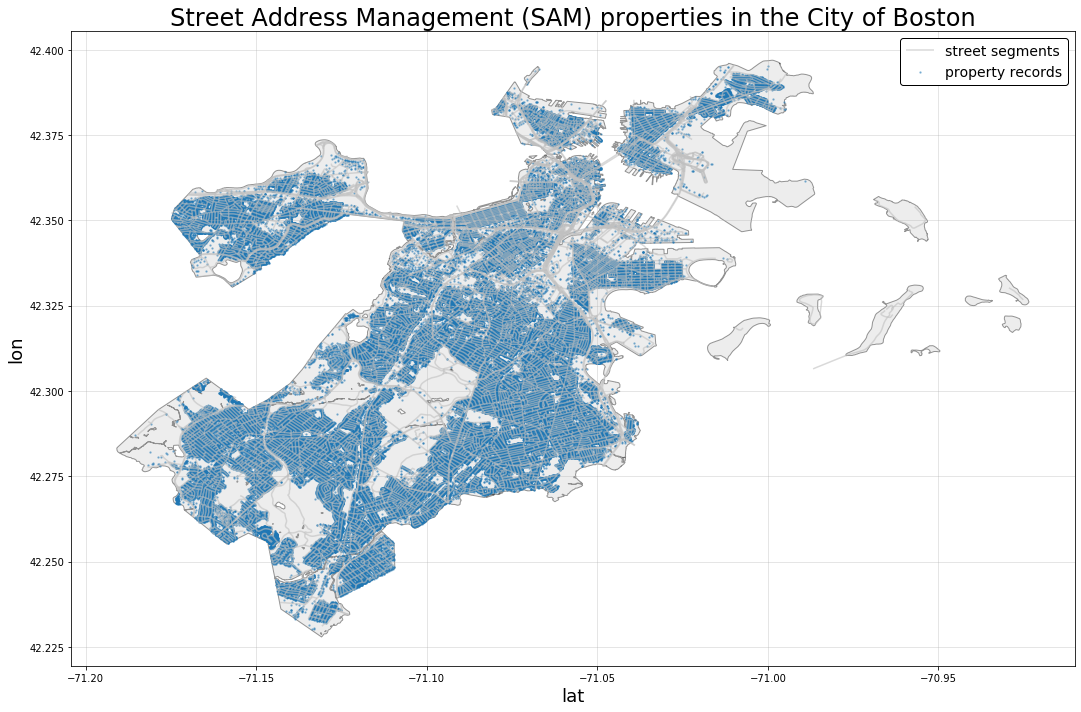

CPU times: user 2.81 s, sys: 30.2 ms, total: 2.84 s
Wall time: 2.6 s


In [6]:
%%time

# plot unique SAM records with city boundary and street segments overlays 
fig, ax = plt.subplots(figsize=(16,10))
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='silver', edgecolor='k', alpha=.6, label='street segments')
plt.title('Street Address Management (SAM) properties in the City of Boston', fontsize=24)
plt.scatter(df_locs['X'], df_locs['Y'], alpha=0.4, s=2, label='property records')
plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=14)
plt.tight_layout()
plt.show();

In [7]:
%%time

# create unique property record counts for each street by name and by id 
prop_streets = df_locs['FULL_STREET_NAME'].value_counts().sort_index().index
street_ids = df_locs['STREET_ID'].value_counts().sort_index().index

# create master key for matching street id numbers to corresponding street names
street_id_key = df_locs.groupby('STREET_ID').agg(
    {
        'FULL_STREET_NAME': 'first'
    }
)

# generate array with all unique pairwise street id combination
# this will be used to evaluate all possible street intersections
street_id_combos = np.array(list(itertools.combinations(street_ids, 2)))

CPU times: user 3.24 s, sys: 260 ms, total: 3.5 s
Wall time: 3.5 s


In [8]:
print(
    'There are:\n\n\t1) {0:,} unique street names\n\t2) {1:,} unique street ids, '\
    'resulting in...\n\t3) {2:,} possible pairwise street id combinations to evaluate '\
    'as possible intersections.\n'.format(
        len(prop_streets), len(street_ids), len(street_id_combos)
    )
)

There are:

	1) 4,085 unique street names
	2) 4,350 unique street ids, resulting in...
	3) 9,459,075 possible pairwise street id combinations to evaluate as possible intersections.



In [9]:
print(street_id_combos[:5])
street_id_key.head()

[['1' '10']
 ['1' '100']
 ['1' '1000']
 ['1' '1001']
 ['1' '1002']]


,FULL_STREET_NAME
STREET_ID,
1,A St
10,Academy Ter
100,Altair Rd
1000,Copeland Pl
1001,Copeland St


In [43]:
# create dictionary of street id to street name for mapping values
street_id_map_dict = dict(zip(street_id_key.index, street_id_key.values.ravel()))

In [10]:
%%time

# create dictionary of arrays for all properties associated with each street id
# each key is a unique street_id, each value is an np.array of the lat/lon
# coordinates for every property on that street
street_arrays = {
    street_id: df_locs.loc[df_locs['STREET_ID']==street_id][['X', 'Y']].values
    for street_id in street_ids
}

CPU times: user 38.9 s, sys: 61.5 ms, total: 39 s
Wall time: 39 s


In [11]:
# confirm dict length matches list of unique street_ids
len(street_arrays) == len(street_ids)

True

In [65]:
# define functions for measuring distance between properties and to identify
# possible intersections

def distance(locs1, locs2, r=3958.75, meters=True):
    """
    Converts distances between lat/lon points to meters using the Haversine
    formula for measuring distance on a sphere

    If the desire is to measure pairwise distances between two coordinate
    arrays of equal length, or between two single sets of coordinates, this
    function can simply be called as `distance(locs1, locs2)`

    If the desire is to measure the distances of each coordinate in array 1
    all coordinates in array 2, the function needs to be called in this
    manner `distance(locs1[:, None], locs2)`
    
    locs1: np.array or list of lat/lon points
    locs2: np.array or list of lat/lon points
    r: float, default=3958.75, great sphere approximated radius of the earth
       in kilometers
    meters: boolean, default=True, specifies the output
            units of the distances returned by this function, meters if True,
            and kilometers if False
    
    returns: np.array of the distances between coordinates in either meters
             or kilometers
    """
    if meters:
        r = r * 1000
    
    # convert lat/lon coordinates to radians
    locs1 = locs1 * np.pi / 180
    locs2 = locs2 * np.pi / 180
    
    cos_lat1 = np.cos(locs1[..., 0])
    cos_lat2 = np.cos(locs2[..., 0])
    
    cos_lat_d = np.cos(locs1[..., 0] - locs2[..., 0])
    cos_lon_d = np.cos(locs1[..., 1] - locs2[..., 1])
    
    return r * np.arccos(cos_lat_d - cos_lat1 * cos_lat2 * (1 - cos_lon_d))


def id_intersections(street_id_combos, street_arrays, street_id_dict, threshold, verbose=False):
    """
    Evaluates street combinations to determine if they likely intersect, and if they
    so, approximates an intersection lat/lon coordinate based on observed property
    locations.
    
    street_id_combos: np.array containing possible pairwise combinations of streets
                      to evaluate for intersections
    street_arrays: dictionary in which each key is a street id and the corresponding
                   value is an np.array of all property location coordinates on that
                   street
    street_id_dict: dictionary for mapping street ids to street names, each key
                    is a street id and each value the corresponding street name
    threshold: integer or float of threshold distance between nearest properties in two
               pairwise street arrays, below which the streets are classified as
               intersecting
    verbose: boolean, defaul=False, if True prints summary of number of street pairings
             evaluated and number of probable intersections identified
    
    returns: pd.DataFrame containing approximated intersection locations
    """
    # generate np.array of distances between all properties on every street combo
    street_arrays_distances = np.array([
        distance(street_arrays[combo[0]][:, None], street_arrays[combo[1]], meters=True)
        for combo in street_id_combos
    ])
    
    # generate np.array of booleans indicating combos have a distance below
    # the threshold distance 
    intersections_bool = np.array([
        np.min(distances) < threshold
        for distances in street_arrays_distances
    ])
    
    # generate np.array of indices identifying the specific 'shortest distance'
    # points for each combo with a set of points closer than the threshold
    shortest_dist_indices = np.array([
        np.argwhere(distances == np.min(distances))[0][0]
        for distances in street_arrays_distances[intersections_bool]
    ])
    
    # subset the list of possible street_id_combos to include only those
    # with points closer than the threshold
    intersections_id_combos = street_id_combos[intersections_bool]
    
    # subset street arrays to include only intersecting streets
    street_arrays_intersections = np.array([
        street_arrays[combo[0]]
        for combo in intersections_id_combos
    ])
    
    # identify approximated coordinates of intersecting street
    intersection_coords = np.array([
        street_arrays_intersections[i][shortest_dist_index]
        for i, shortest_dist_index in enumerate(shortest_dist_indices)
    ])

    if verbose:
        print(
            '{0:,} street arrays distances calculated, '\
            '{1:,} intersection returned with a threshold'\
            'of {2:} meters.'.format(
                len(street_arrays_distances),
                len(intersection_coords),
                threshold
            )
        )
    
    # store results and associated information to a dataframe for easy analysis
    intersections_df = pd.DataFrame(
        {
            'street_id': intersections_id_combos[:, 0],
            'cross_id': intersections_id_combos[:, 1],
            'street': pd.Series(intersections_id_combos[:,0]).map(street_id_map_dict).values,
            'cross': pd.Series(intersections_id_combos[:,1]).map(street_id_map_dict).values,
            'lat': intersection_coords[:,0],
            'lon': intersection_coords[:,1],
            'threshold': threshold
        }
    )
    
    return intersections_df

In [30]:
%%time
locs1 = 2657 # Mass ave
locs2 = 2139 # Huntington Ave


test_dist = distance(street_arrays['2657'][:, None], street_arrays['2139'], meters=False)

test_dist.shape

CPU times: user 10.1 ms, sys: 39 µs, total: 10.2 ms
Wall time: 2.86 ms


(610, 367)

In [31]:
test_dist

array([[1.60731226, 1.60737268, 1.59597485, ..., 0.86549582, 0.871978  ,
        0.8722469 ],
       [1.61963552, 1.61959579, 1.60827542, ..., 0.84835564, 0.85517846,
        0.85544909],
       [1.62340532, 1.62338955, 1.61205056, ..., 0.84611132, 0.85278588,
        0.85305578],
       ...,
       [3.49966885, 3.49646447, 3.48821393, ..., 1.22857608, 1.23343327,
        1.23324938],
       [3.49966888, 3.4964645 , 3.48821396, ..., 1.2285761 , 1.23343329,
        1.2332494 ],
       [3.50814442, 3.50493383, 3.49669057, ..., 1.2372512 , 1.24207694,
        1.24189275]])

In [52]:
locs1 = '2657' # Mass ave
locs2 = '2139' # Huntington Ave
threshold = 100

mass_hunt_intersection = id_intersections(
    np.array([[locs1, locs2]]),
    street_arrays,
    street_id_map_dict,
    threshold,
    verbose=False
)

threshold_test = np.array(
    [street_arrays[locs1][120][0]+threshold,
     street_arrays[locs1][120][1]+threshold]
)

In [53]:
mass_hunt_intersection

,street_id,cross_id,street,cross,lat,lon,threshold
0,2657,2139,Massachusetts Ave,Huntington Ave,-71.085683,42.342843,100


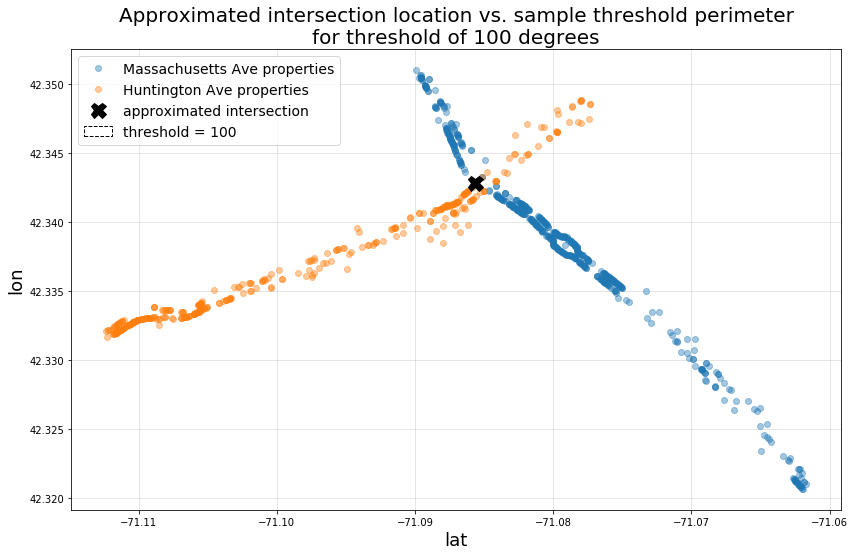

In [54]:
fig, ax = plt.subplots(figsize=(12,12))

plt.title(
    'Approximated intersection location vs. sample threshold perimeter\n'\
    'for threshold of {0} degrees'\
    ''.format(threshold), 
    fontsize=20
)

for street_id in [locs1, locs2]:
    plt.plot(
        street_arrays[street_id][:,0],
        street_arrays[street_id][:,1],
        'o',
        alpha=.4,
        label='{0} properties'.format(street_id_map_dict[street_id])
    )

plt.plot(
    mass_hunt_intersection['lat'],
    mass_hunt_intersection['lon'],
    'kX',
    markersize=15,
    label='approximated intersection'
)
circle = mpatches.Circle(
    xy=[mass_hunt_intersection['lat'], mass_hunt_intersection['lon']],
    radius=threshold,
    ec='k',
    linestyle='--',
    fill=False,
    label='threshold = {0}'.format(threshold)
)
ax.add_patch(circle)
plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
ax.set_aspect('equal')
plt.legend(fontsize=14)
plt.grid(':', alpha=0.4)
plt.tight_layout()
plt.show();

In [55]:
%%time
threshold = 100
n_splits = 50 # because the kernel will crash if more than 500K are processed at a time
splits = np.array_split(street_id_combos, n_splits)

street_id_map_dict = {
    street_id: street_name
    for street_id, street_name in zip(
        street_id_key.index,
        street_id_key['FULL_STREET_NAME']
    )
}

print('SPLIT 1:')
intersections_df = id_intersections(
    splits[0],
    street_arrays,
    street_id_map_dict,
    threshold,
    verbose=True
)
print()

for i, split in enumerate(splits[1:]):
    print('SPLIT {}:'.format(i+2)) 
    intersections_df = pd.concat(
         [
             intersections_df,
             id_intersections(
                 split,
                 street_arrays,
                 street_id_map_dict,
                 threshold,
                 verbose=True
             )
         ], ignore_index=True
     )
    print('{0:,} cumulative intersections identified\n'.format(len(intersections_df)))

SPLIT 1:
189,182 street arrays distances calculated, 1,383 intersection coordinates returned with a threshold of 100.

SPLIT 2:
189,182 street arrays distances calculated, 1,159 intersection coordinates returned with a threshold of 100.
2,542 cumulative intersections identified

SPLIT 3:
189,182 street arrays distances calculated, 1,207 intersection coordinates returned with a threshold of 100.
3,749 cumulative intersections identified

SPLIT 4:
189,182 street arrays distances calculated, 1,250 intersection coordinates returned with a threshold of 100.
4,999 cumulative intersections identified

SPLIT 5:
189,182 street arrays distances calculated, 1,144 intersection coordinates returned with a threshold of 100.
6,143 cumulative intersections identified

SPLIT 6:
189,182 street arrays distances calculated, 1,493 intersection coordinates returned with a threshold of 100.
7,636 cumulative intersections identified

SPLIT 7:
189,182 street arrays distances calculated, 1,216 intersection coor

In [56]:
intersections_df.shape

(63182, 7)

In [57]:
intersections_df.head()

,street_id,cross_id,street,cross,lat,lon,threshold
0,1,1121,A St,Dacy St,-71.125670,42.250592,100
1,1,1133,A St,Dana Ave,-71.125037,42.250627,100
2,1,1323,A St,Easton Ave,-71.124891,42.250328,100
3,1,1475,A St,Factory St,-71.125670,42.250592,100
4,1,1494,A St,Faraday St,-71.125401,42.250469,100


In [74]:
if not os.path.exists(WRITE_DIR):
    os.mkdir(WRITE_DIR)

intersections_df.to_csv(
    os.path.join(WRITE_DIR, 'intersections-{0}.csv'.format(threshold)),
    index=False
)

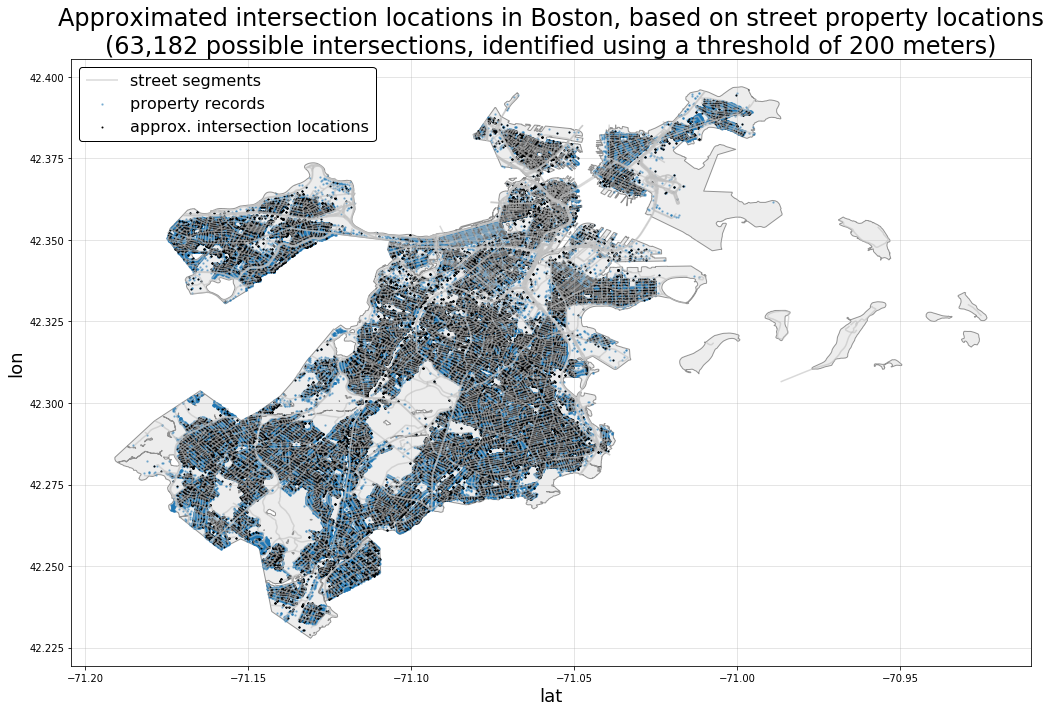

CPU times: user 3.43 s, sys: 44 ms, total: 3.48 s
Wall time: 3.47 s


In [68]:
%%time

fig, ax = plt.subplots(figsize=(16,10))
plt.title(
    'Approximated intersection locations in Boston, based on street property locations\n'\
    '({0:,} possible intersections, identified using a threshold of {1} meters)'.format(
        len(intersections_df),
        threshold
    ), 
    fontsize=24
)
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='silver', edgecolor='k', alpha=.6, label='street segments')
plt.scatter(df_locs['X'], df_locs['Y'], alpha=0.4, s=2, label='property records')
plt.scatter(
    intersections_df['lat'],
    intersections_df['lon'],
    color='k',
    s=1,
    alpha=1,
    label='approx. intersection locations'
)
plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=16)
plt.tight_layout()
plt.show();

In [63]:
street_id_key[street_id_key['FULL_STREET_NAME'].str.contains('American Legion')]

,FULL_STREET_NAME
STREET_ID,
112,American Legion Hwy


In [64]:
street_id_key[street_id_key['FULL_STREET_NAME'].str.contains('Hunt')]

,FULL_STREET_NAME
STREET_ID,
2138,Hunter St
2139,Huntington Ave
2140,Huntington Ave
2141,Huntington Rd
2142,S Huntington Ave
2143,Huntoon St


In [69]:
%%time
threshold = 200
n_splits = 50 # because the kernel will crash if more than 500K are processed at a time
splits = np.array_split(street_id_combos, n_splits)

street_id_map_dict = {
    street_id: street_name
    for street_id, street_name in zip(
        street_id_key.index,
        street_id_key['FULL_STREET_NAME']
    )
}

print('SPLIT 1:')
intersections_df_200 = id_intersections(
    splits[0],
    street_arrays,
    street_id_map_dict,
    threshold,
    verbose=True
)
print()

for i, split in enumerate(splits[1:]):
    print('SPLIT {}:'.format(i+2)) 
    intersections_df_200 = pd.concat(
         [
             intersections_df_200,
             id_intersections(
                 split,
                 street_arrays,
                 street_id_map_dict,
                 threshold,
                 verbose=True
             )
         ], ignore_index=True
     )
    print('{0:,} cumulative intersections identified\n'.format(len(intersections_df_200)))

SPLIT 1:
189,182 street arrays distances calculated, 3,163 intersection returned with a thresholdof 200 meters.

SPLIT 2:
189,182 street arrays distances calculated, 2,711 intersection returned with a thresholdof 200 meters.
5,874 cumulative intersections identified

SPLIT 3:
189,182 street arrays distances calculated, 2,648 intersection returned with a thresholdof 200 meters.
8,522 cumulative intersections identified

SPLIT 4:
189,182 street arrays distances calculated, 2,846 intersection returned with a thresholdof 200 meters.
11,368 cumulative intersections identified

SPLIT 5:
189,182 street arrays distances calculated, 2,757 intersection returned with a thresholdof 200 meters.
14,125 cumulative intersections identified

SPLIT 6:
189,182 street arrays distances calculated, 3,287 intersection returned with a thresholdof 200 meters.
17,412 cumulative intersections identified

SPLIT 7:
189,182 street arrays distances calculated, 2,759 intersection returned with a thresholdof 200 meter

In [70]:
intersections_df_200.shape

(143561, 7)

In [73]:
intersections_df_200.to_csv(
    os.path.join(WRITE_DIR, 'intersections-{0}.csv'.format(threshold)),
    index=False
)

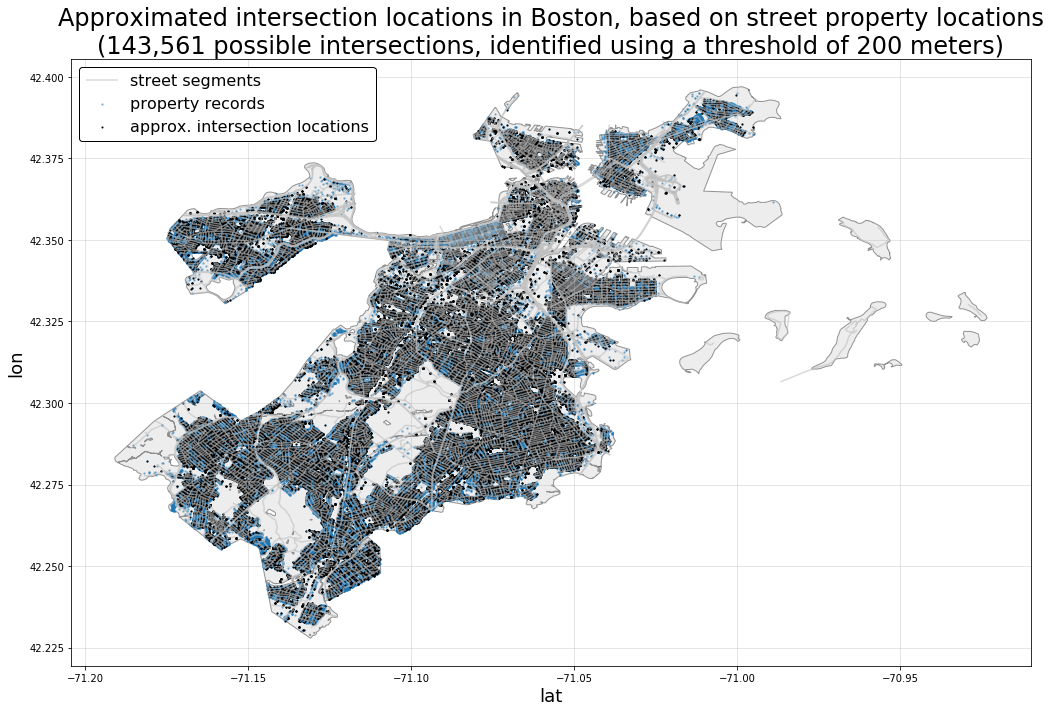

CPU times: user 4.38 s, sys: 68 ms, total: 4.45 s
Wall time: 4.45 s


In [76]:
%%time

fig, ax = plt.subplots(figsize=(16,10))
plt.title(
    'Approximated intersection locations in Boston, based on street property locations\n'\
    '({0:,} possible intersections, identified using a threshold of {1} meters)'.format(
        len(intersections_df_200),
        threshold
    ), 
    fontsize=24
)
gdf_boston.plot(ax=ax, color='lightgray', edgecolor='k', alpha=0.4)
gdf_streets.plot(ax=ax, color='silver', edgecolor='k', alpha=.6, label='street segments')
plt.scatter(df_locs['X'], df_locs['Y'], alpha=0.4, s=2, label='property records')
plt.scatter(
    intersections_df_200['lat'],
    intersections_df_200['lon'],
    color='k',
    s=1,
    alpha=1,
    label='approx. intersection locations'
)
plt.xlabel('lat', fontsize=18)
plt.ylabel('lon', fontsize=18)
plt.grid(":", alpha=0.4)
plt.legend(edgecolor='k', framealpha=1, fontsize=16)
plt.tight_layout()
plt.show();